## Dependancies

In [60]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import sksurv
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
import gseapy as gp

In [2]:
print(gp.__version__)

1.1.8


## LUAD Analysis

### Data Import

In [4]:
gene = pd.read_csv('C:\\Users\\andrew\\Desktop\\Jaxen\\Data\\LUAD_raw_counts_DESEQ_input.csv', index_col=0)
de_immune = pd.read_excel('C:\\Users\\andrew\\Desktop\\Jaxen\\Data\\LUAD_DESEQ_immune_genes.xlsx', index_col='Gene')
de = pd.read_csv('C:\\Users\\andrew\\Desktop\\Jaxen\\Data\\LUAD_DESEQ_output.csv', index_col='Gene')
surv = pd.read_csv('C:\\Users\\andrew\\Desktop\\Jaxen\\Data\\LUAD_survival.csv', index_col='Sample')

### Raw Count Normalization

To normalize the raw counts I used edgeR normalization which applies a log transformation to CPM - The +1 is to avoid log(0) (log2(CountsPerMillion + 1))

In [5]:
def counts_to_cpm(counts_df):
    counts_sum = counts_df.sum(axis=0)
    cpm = counts_df.divide(counts_sum, axis=1) * 1e6
    return cpm

cpm = counts_to_cpm(gene)
log_cpm = np.log2(cpm + 1)

# Make column and index names strings
log_cpm.columns = log_cpm.columns.astype(str)
log_cpm.index = log_cpm.index.astype(str)

Beyond CPM scaling, I would also like all of the data to be on the same scale. This can be thought of like a z-score normalization, where each gene is fit to a normal distribution with a mean=0, and std=1. This ensures 'equal' contribution of each feature when fitting LASSO. 

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(log_cpm.T)  # transpose so shape is (samples, genes)
ScaledGene = pd.DataFrame(X_scaled, index=log_cpm.columns, columns=log_cpm.index)

### Univariate Cox-Proportional Hazard Modeling

Before we run LASSO regression, it is likely a good idea to filter out all of the genes that are not (univariately - individually) associated with outcome. after applying this filtering criteria, we are left with 7 genes/features. 

In [7]:
immuneGene = ScaledGene.loc[surv.index, de_immune.index]
immuneSurv = immuneGene
immuneSurv['time'] = surv['OS.time']
immuneSurv['event'] = surv['OS']

In [8]:
results = []

for gene in immuneGene.columns:
    cph = CoxPHFitter()
    df_gene = immuneSurv[[gene, 'time', 'event']]
    try:
        cph.fit(df_gene, duration_col='time', event_col='event')
        summary = cph.summary
        results.append({
            'gene': gene,
            'coef': summary.loc[gene, 'coef'],
            'HazardRation': summary.loc[gene, 'exp(coef)'],
            'p-value': summary.loc[gene, 'p'],
        })
    except Exception as e:
        print(f"Skipping {gene}: {e}")

univariate_results = pd.DataFrame(results)
univariate_results = univariate_results.sort_values(by='p-value')

sig_univariate_genes = univariate_results[univariate_results['p-value'] < 0.05]['gene'].tolist()
print(sig_univariate_genes)

Skipping time: The column label 'time' is not unique.
Skipping event: The column label 'event' is not unique.
['APOL1', 'DEFB1', 'CXCL8', 'CXCL5', 'LIF', 'DPP4-DT', 'IGLV4-60']


### LASSO Regression

In [9]:
LASSO = immuneSurv.copy()
LASSO_X = LASSO.loc[:, sig_univariate_genes]

time = LASSO['time']
event = LASSO['event']
LASSO_y = Surv.from_arrays(event.astype(bool), time)

My first question was: how related are these 7 features to each other? if they are all highly related, then how would we (LASSO) estabolish which feature is most important? Thankfully, your gene features have reasonably low multicollinearity - or at least well below the threshold of (+/- 0.8) which denotes the upper-limit of elastic-shrinkage

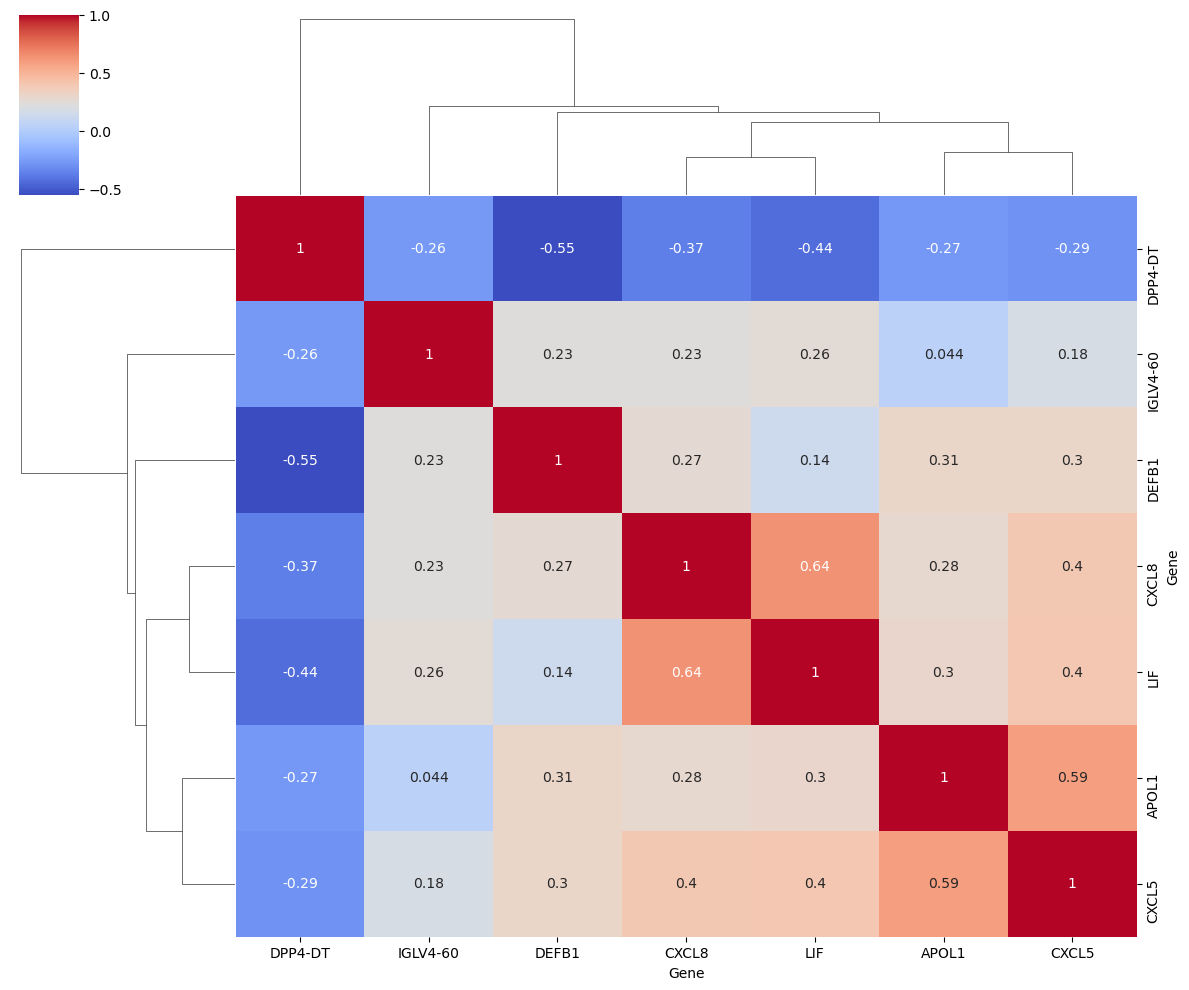

In [10]:
sns.clustermap(LASSO_X.corr(), cmap="coolwarm", figsize=(12, 10), annot=True)

LASSO makes use if a parameter called 'alpha'. This parameter denotes how agressive you would like to be in removing features, high alpha would apply agressive filtering and therefore would likely have less features. How do we know what alpha value is optimal for our dataset? That is what I am investigating below. 

In [11]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(LASSO_X, LASSO_y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

To figure this out, I simply 'boot-strapped' all alpha possibilities and below shows the LASSO 'coeffiecent' (which represents the strength of that feature in predicting outcome) as I increase that alpha value (x-axis)

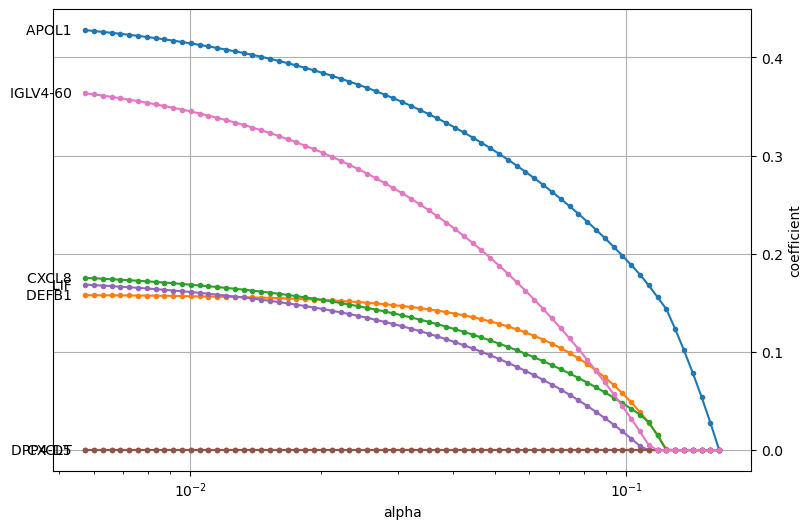

In [12]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=LASSO_X.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=7)

In [13]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
coxnet_pipe.fit(LASSO_X, LASSO_y)

c:\Users\andrew\.conda\envs\SingleCellSequencing\lib\site-packages\sklearn\pipeline.py:405: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [14]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in map(float, estimated_alphas)]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(LASSO_X, LASSO_y)

cv_results = pd.DataFrame(gcv.cv_results_)

c:\Users\andrew\.conda\envs\SingleCellSequencing\lib\site-packages\sklearn\pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\andrew\.conda\envs\SingleCellSequencing\lib\site-packages\sklearn\pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\andrew\.conda\envs\SingleCellSequencing\lib\site-packages\sklearn\pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\andrew\.conda\envs\SingleCellSequencing\lib\site-packages\sklearn\pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\andrew\.conda\envs\SingleCellSequencing\lib\site-packages\sklearn\pipeline.py:405: UserWarning: all coefficients are ze

Okay, we have all the alpha and feature data, how do we pick the most optimal alpha? We selected the alpha value that gives us the highest 'concordance index' (or highest agreement with all other assessed alpha values) - plot below. 

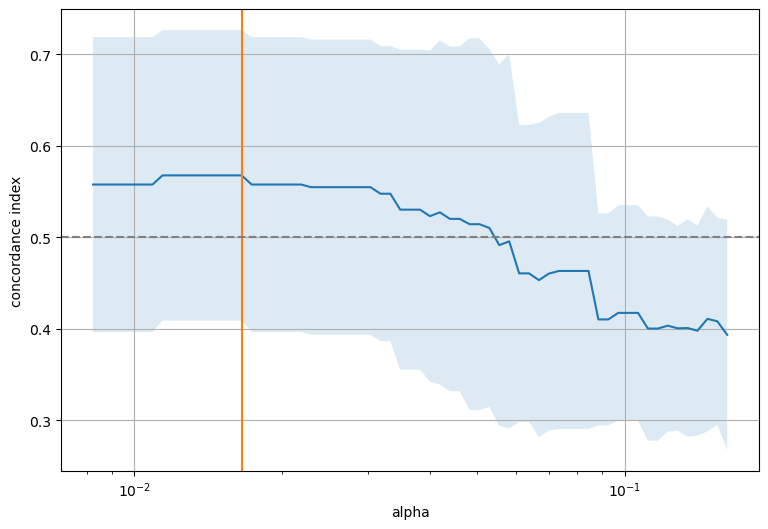

In [15]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Our best model has the following genes as features. Note all coefficient values (denoting relevance to outcome) are positive, meaning expression of that gene is associated with a WORSE outcome. This coefficient is a relative value, so this is also stating that APOL1 is the most associated with poor outcome, and LIF is the least associated.

Number of non-zero coefficients: 5


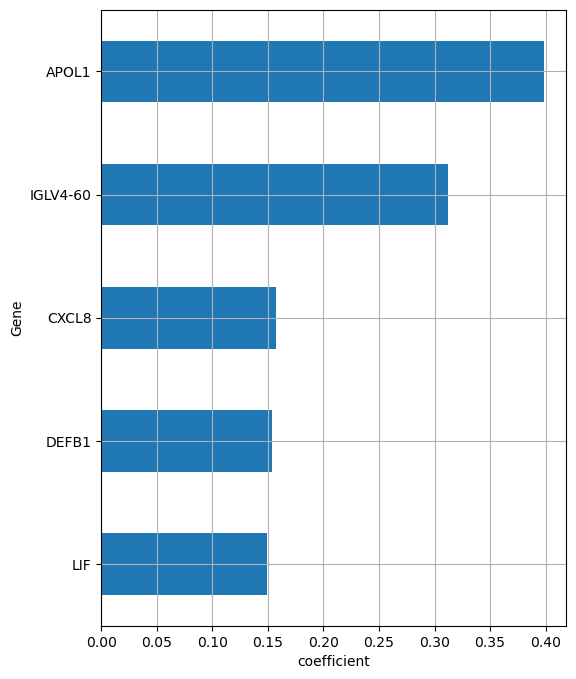

In [16]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=LASSO_X.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### GSVA

I then took these features and created a geneset I called 'Lung Tumor Associate Neutrophils. Importantly, I named this pathway and it is composed of our 5 prognositic genes

In [44]:
gsva_results= gp.gsva(
    data=log_cpm,
    gene_sets={'Lung_Tumor_Associated_Neutrophils': ['APOL1', 'IGLV4-60', 'CXCL8', 'DEFB1', 'LIF']},
    outdir=None,
    min_size=1,
    verbose=True
)

2025-04-02 13:54:05,453 [INFO] Parsing data files for GSVA.............................
2025-04-02 13:54:05,472 [INFO] Estimating ECDFs with Gaussian kernels.
2025-04-02 13:54:05,494 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=1
2025-04-02 13:54:05,495 [INFO] 0001 gene_sets used for further statistical testing.....
2025-04-02 13:54:05,496 [INFO] Start to run GSVA...Might take a while................
2025-04-02 13:54:06,079 [INFO] Done


Here is the distribution (histogram) of the expression of this geneset within the LUAD dataset.

<Axes: >

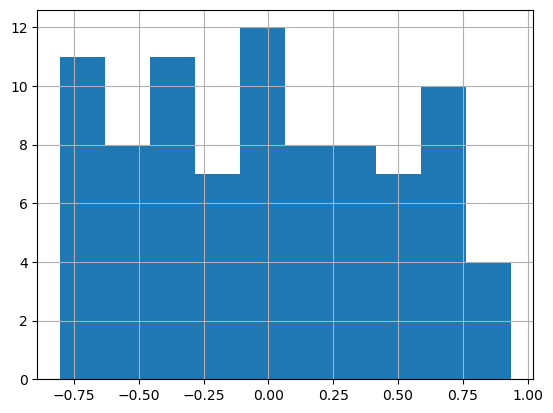

In [50]:
gsva_scores = gsva_results.res2d
gsva_scores['ES'].hist()

In [54]:
median_score = gsva_scores['ES'].median()
gsva_scores['MedianS'] = (gsva_scores['ES'] >= median_score).astype(int)

In [56]:
gsva_scores.index = gsva_scores['Name']
print(gsva_scores)

                Name                               Term        ES  High_ES  \
Name                                                                         
C3L-00009  C3L-00009  Lung_Tumor_Associated_Neutrophils  0.770487        1   
C3N-00704  C3N-00704  Lung_Tumor_Associated_Neutrophils -0.651923        0   
C3N-01415  C3N-01415  Lung_Tumor_Associated_Neutrophils -0.043709        0   
C3N-01413  C3N-01413  Lung_Tumor_Associated_Neutrophils  0.113286        1   
C3N-01405  C3N-01405  Lung_Tumor_Associated_Neutrophils -0.337682        0   
...              ...                                ...       ...      ...   
C3L-01330  C3L-01330  Lung_Tumor_Associated_Neutrophils -0.779961        0   
C3N-00959  C3N-00959  Lung_Tumor_Associated_Neutrophils -0.070529        0   
C3L-00893  C3L-00893  Lung_Tumor_Associated_Neutrophils -0.763981        0   
C3L-00604  C3L-00604  Lung_Tumor_Associated_Neutrophils -0.037533        0   
C3N-01414  C3N-01414  Lung_Tumor_Associated_Neutrophils  0.44255

### Kaplan Meier

Does the expression of this pathway actually seperate patients by outcome? 

In [63]:
surv['GSVA_median_split'] = gsva_scores['High_ES']
surv['GSVA_score'] = gsva_scores['ES']

I started by just median splitting the patients into two groups (above or below median) on the basis of their 'lung tumor associated neutrophil' pathway expression, and I do see statistically significant difference in the outcome (log-rank pval = 0.041)

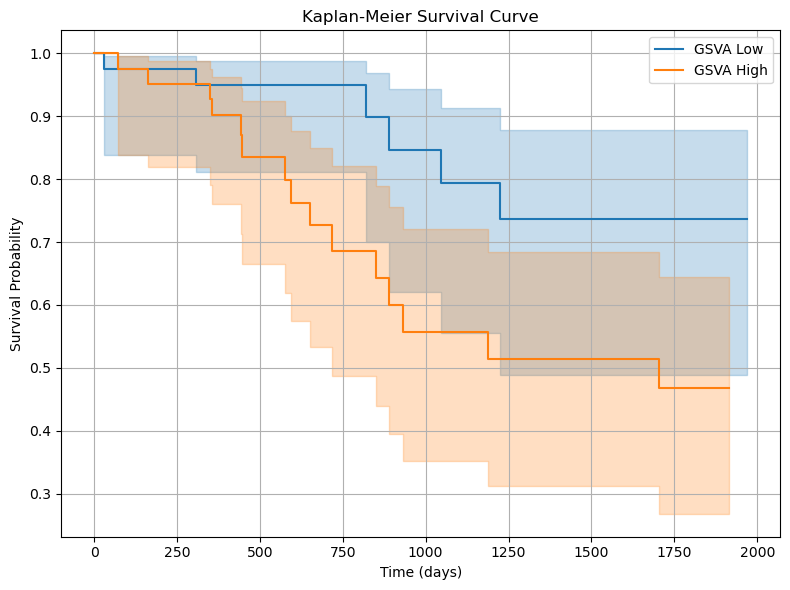

Log-rank test p-value: 0.04161230240993966


In [64]:
# Assuming 'surv' is your DataFrame
# Columns: 'OS.time' = survival time, 'OS' = event (1 = death), 'GSVA_median_split' = binary group

# Split by GSVA group
group0 = surv[surv['GSVA_median_split'] == 0]
group1 = surv[surv['GSVA_median_split'] == 1]

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plotting
plt.figure(figsize=(8, 6))

# Plot Group 0
kmf.fit(durations=group0["OS.time"], event_observed=group0["OS"], label="GSVA Low")
ax = kmf.plot_survival_function()

# Plot Group 1
kmf.fit(durations=group1["OS.time"], event_observed=group1["OS"], label="GSVA High")
kmf.plot_survival_function(ax=ax)

# Styling
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Log-rank test
results = logrank_test(
    group0["OS.time"], group1["OS.time"],
    event_observed_A=group0["OS"],
    event_observed_B=group1["OS"]
)

print("Log-rank test p-value:", results.p_value)


### Log-Rank Optimized Split

Surely, the median value isnt the best way to segment our groups. To optimally seperate them, I used something called log-rank optimization. This procedure is similar to the boot-strapping above, where the software attempts to find the lowest log-rank p-value, given a very large series of splits. Doing so, gives us a more significant cut-point of 0.23 (GSVA value), yeilding a log-rank p-value = 0.0117 (see below) 

In [65]:
print(surv)

           OS.time  OS  GSVA_median_split GSVA_score
Sample                                              
C3L-00893     23.0   0                  0  -0.763981
C3N-02586     30.0   1                  0  -0.540696
C3L-00510     38.0   0                  0  -0.754756
C3N-01071     44.0   0                  1   0.188709
C3N-00223     49.0   0                  0  -0.445732
...            ...  ..                ...        ...
C3N-02421   1896.0   0                  0  -0.737983
C3L-00422   1916.0   0                  1    0.38436
C3N-02380   1932.0   0                  0  -0.698025
C3L-02350   1950.0   0                  0  -0.251451
C3N-02067   1970.0   0                  0  -0.742501

[84 rows x 4 columns]


In [67]:
def find_optimal_cutpoint(df, score_col='gsva_score', time_col='time', event_col='event'):
    best_p = 1
    best_cut = None

    cutpoints = np.percentile(df[score_col], np.arange(20, 80, 1))  # Avoid extremes

    for cut in cutpoints:
        low = df[df[score_col] <= cut]
        high = df[df[score_col] > cut]

        result = logrank_test(
            low[time_col], high[time_col],
            event_observed_A=low[event_col],
            event_observed_B=high[event_col]
        )

        if result.p_value < best_p:
            best_p = result.p_value
            best_cut = cut

    return best_cut, best_p

cut_point, p_value = find_optimal_cutpoint(surv, 'GSVA_score', 'OS.time', 'OS')

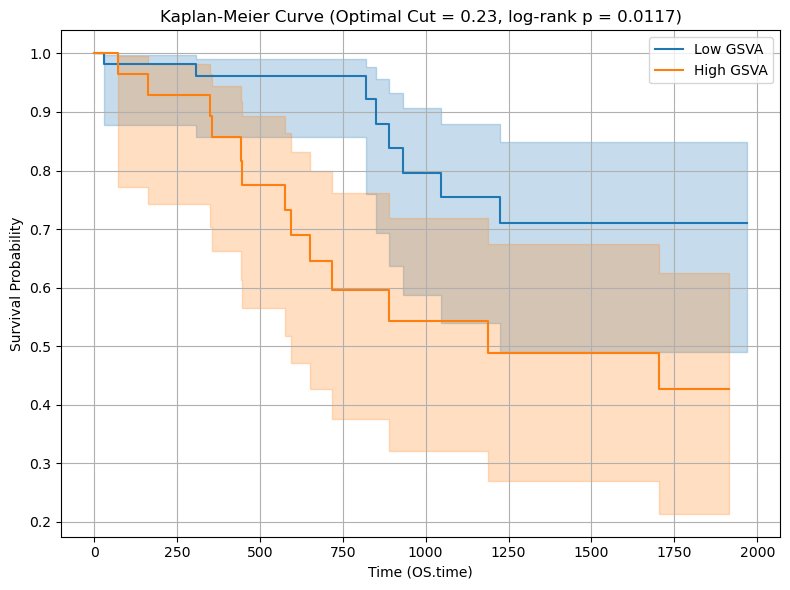

In [70]:
# Add a new column for group assignment
surv['log_rank_optimized_group'] = surv['GSVA_score'].apply(lambda x: 'High' if x > cut_point else 'Low')

# Split data into two groups
low_group = surv[surv['log_rank_optimized_group'] == 'Low']
high_group = surv[surv['log_rank_optimized_group'] == 'High']

# Initialize KM fitters
kmf_low = KaplanMeierFitter()
kmf_high = KaplanMeierFitter()

# Plot
plt.figure(figsize=(8, 6))

kmf_low.fit(durations=low_group['OS.time'], event_observed=low_group['OS'], label='Low GSVA')
kmf_low.plot(ci_show=True)

kmf_high.fit(durations=high_group['OS.time'], event_observed=high_group['OS'], label='High GSVA')
kmf_high.plot(ci_show=True)

plt.title(f"Kaplan-Meier Curve (Optimal Cut = {cut_point:.2f}, log-rank p = {p_value:.4f})")
plt.xlabel("Time (OS.time)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()